<h2>Requirements</h2>

In [ ]:
#!pip install opencv-python

In [ ]:
#pip install tensorflow
# !pip install --upgrade tensorflow
# print(tf.__version__)
# print(tf.keras.__version__)

In [1]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
#!pip install keras

In [ ]:
#!pip install plotly

<h2>Data Description</h2>

The data which is used in this research is taken from the <b style="font-size: 20px"><a href="https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data">plant-pathology-2020-fgvc7</a></b>

<h3>1. Images</h3>
<p>A folder containing the train and test images, in jpg format.</p>

<h3>2. Train Data</h3><p>(train.csv)</p>

<p>Data which is used to train the models is stored in this file</p>

<h5>Columns:</h5>

<p><b>image_id:</b> ID of the image which is located in images folder</p>
<p><b>healthy</b> This column describes if the leaf is healthy or unhealthy if healthy it is marked as 1 else it is 0</p>
<p><b>scab</b> This column describes if the leaf is diseased with Scab or not if the leaf is effected with Scab it is marked as 1 else it is 0</p>
<p><b>rust</b> This column describes if the leaf is diseased with Rust or not if the leaf is effected with Rust it is marked as 1 else it is 0</p>
<p><b>multiple_diseases</b> This column describes if the leaf is diseased with multiple diseases (like scab and rust) or not if the leaf is effected with multiple diseases it is marked as 1 else it is 0</p>

<h3>3. Test Data</h3>

<p>This data is used to test the model how effectively the model is working on unseen data</p>

<h5>Columns:</h5>
<p><b>image_id:</b> ID of the image which is located in images folder</p>

In [2]:
import gc
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2

from tqdm import tqdm
# tqdm.pandas()

import tensorflow as tf

import efficientnet.tfkeras as efn

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

from kaggle_datasets import KaggleDatasets

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

<h2>Load the Data</h2>

In [3]:
DIR_INPUT = '../input/plant-pathology-2020-fgvc7'
train_data_path = DIR_INPUT + "/train.csv"
test_data_path = DIR_INPUT + "/test.csv"
images_path = DIR_INPUT + "/images/"

In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

In [5]:
train = pd.read_csv(train_data_path)

In [6]:
test = pd.read_csv(test_data_path)

<h2>Exploring the Data</h2>

In [7]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [8]:
# Rows and Columns in the data

train.shape

(1821, 5)

In [9]:
# summary of the dataset: 1821 rows, 5 columns, no null values

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB
None


In [10]:
# Data Description

train.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


#### Structure of test data

In [11]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [12]:
# Rows and Columns in the test data

test.shape

(1821, 1)

In [13]:
# Let us find the duplicates in the dataset if any in train data

bool_series = train["image_id"].duplicated()
len(bool_series[bool_series].index.values)

0

In [14]:
# Let us find the duplicates in the dataset if any in test data

bool_series = train["image_id"].duplicated()
len(bool_series[bool_series].index.values)

0

There are no duplicate images in both train and test data.

In [15]:
# Let us find the missing values percentage of train data in column wise

missing_values = round(100*(train.isnull().sum()/len(train.index)),2)
missing_values

image_id             0.0
healthy              0.0
multiple_diseases    0.0
rust                 0.0
scab                 0.0
dtype: float64

In [16]:
# Let us find the missing values percentage of test data in column wise

missing_values = round(100*(test.isnull().sum()/len(test.index)),2)
missing_values

image_id    0.0
dtype: float64

#### Data Distribution

In [17]:
def plot_data_distribution(column_name, labels = [], colours = [], xlabel='', ylabel=''):
    plt.bar(labels, train[column_name].value_counts(), color=colours)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.annotate('{}\n({:.4}%)'.format(train[column_name].value_counts()[0], 
                                             train[column_name].value_counts()[0]/train[column_name].count()*100),
                 (0.20, 0.45), xycoords='axes fraction')
    plt.annotate('{}\n({:.4}%)'.format(train[column_name].value_counts()[1], 
                                             train[column_name].value_counts()[1]/train[column_name].count()*100),
                 (0.70, 0.45), xycoords='axes fraction')
    plt.tight_layout()
    plt.show()

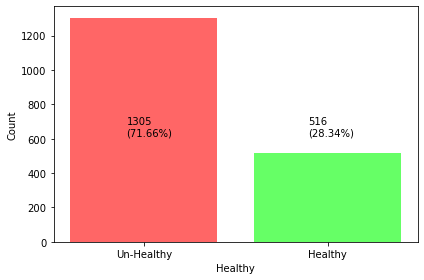

In [18]:
# Letus find the number of healthy and non-healthy leafs from data
plot_data_distribution('healthy', labels=['Un-Healthy', 'Healthy'], colours=['#FF6666','#66FF66'], xlabel='Healthy', ylabel='Count')

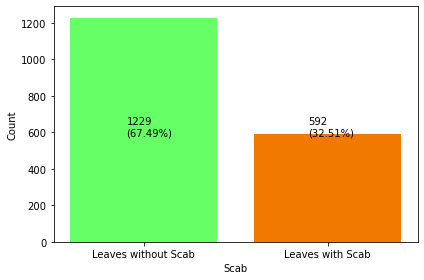

In [19]:
# Letus find the number of Scab leaves and non-scab leaves from data
plot_data_distribution('scab', labels=['Leaves without Scab', 'Leaves with Scab'], colours=['#66FF66', '#F27900'], xlabel='Scab', ylabel='Count')

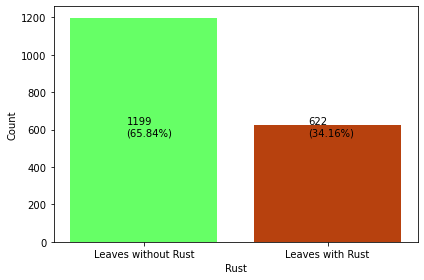

In [20]:
# Letus find the number of Rust leaves and non-rust leaves from data

plot_data_distribution('rust', labels=['Leaves without Rust', 'Leaves with Rust'], colours=['#66FF66', '#b7410e'], xlabel='Rust', ylabel='Count')

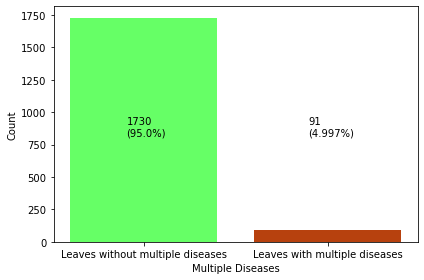

In [21]:
# Letus find the number of Multiple diseased leaves and leaves without multiple diseases from data

plot_data_distribution('multiple_diseases', labels=['Leaves without multiple diseases', 'Leaves with multiple diseases'], colours=['#66FF66', '#b7410e'], xlabel='Multiple Diseases', ylabel='Count')

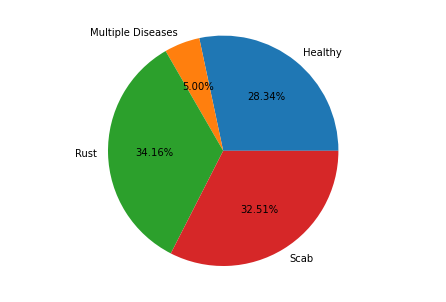

In [22]:
# Distribution of diseases 

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
leaves = ['Healthy', 'Multiple Diseases', 'Rust', 'Scab']
healthy = len(train[train['healthy'] == 1])
multiple = len(train[train['multiple_diseases'] == 1])
rust = len(train[train['rust'] == 1])
scab = len(train[train['scab'] == 1])
total_count = [healthy, multiple, rust, scab]
ax.pie(total_count, labels = leaves,autopct='%1.2f%%')
plt.show()

#### Sample images from the dataset

In [23]:
# Load images 
def load_image(image_id): 
    image = cv2.imread(images_path + image_id + ".jpg")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
train_images = train["image_id"][:500].apply(load_image)

In [ ]:
# function for loading the images form the dataset
def get_sample_images(image_type, skip = 0, take = 100):
    
    disease_cond_list = []
    if image_type == 'healthy':
        disease_cond_list = [1, 0, 0, 0]
    elif image_type == 'multiple_diseases':
        disease_cond_list = [0, 1, 0, 0]
    elif image_type == 'rust':
        disease_cond_list = [0, 0, 1, 0]
    elif image_type == 'scab':
        disease_cond_list = [0, 0, 0, 1]
    else:
        disease_cond_list = [1, 0, 0, 0]

    if (len(disease_cond_list) > 1 ):
        data = train[(train['healthy'] == disease_cond_list[0]) & (train['scab'] == disease_cond_list[1]) & (train['rust'] == disease_cond_list[2]) & (train['multiple_diseases'] == disease_cond_list[3])][skip:][:take]
        
        images = train_images.loc[list(data.index)]
        cols, rows = 3, min([3, len(images)//3])

        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
        for col in range(cols):
            for row in range(rows):
                ax[row, col].imshow(images.loc[images.index[row*3+col]])
        plt.show()
    else:
        return None

#### Sample images of Healthy Leaves

In [ ]:
get_sample_images("healthy", 3, 6)

#### Sample images of leaves with multiple diseases

In [ ]:
get_sample_images("multiple_diseases", 3, 6)

#### Sample images of leaves with rust

In [ ]:
get_sample_images("rust", 3, 6)

#### Sample images of leaves with scab

In [ ]:
get_sample_images("scab", 3, 6)

#### Preprocessing

In [24]:
image_sample = GCS_DS_PATH + '/images/Train_1307.jpg'

In [25]:
def read_file(fileName, label=None):
    bits = tf.io.read_file(fileName)
    image = tf.image.decode_jpeg(bits, channels=3)
    if label is None:
        return image
    else:
        return image, label

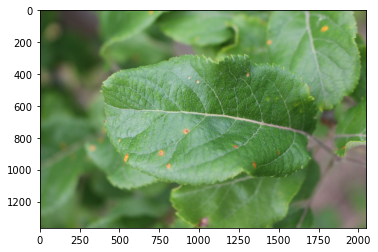

In [26]:
plt.imshow(read_file(image_sample))

In [27]:
def image_brightness(image, label=None, brightness=0.2):
    image = read_file(image)
    image = tf.image.random_brightness(image, brightness)
    if label is None:
        return image
    else:
        return image, label

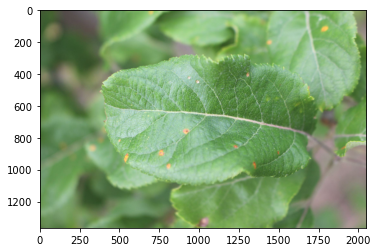

In [28]:
plt.imshow(image_brightness(image_sample))

In [29]:
def image_flipping(image, label=None, flip_type='left_right'):
    image = read_file(image)
    if flip_type == 'left_right':
        image = tf.image.random_flip_left_right(image)
    elif flip_type == 'up_down':
        image = tf.image.random_flip_up_down(image)
    else:
        image = image
    return image

#### Preparing Data

In [30]:
def map_image_with_path(image):
    return GCS_DS_PATH + '/images/' + image + '.jpg'

In [31]:
test_paths = test.image_id.apply(map_image_with_path).values
train_paths = train.image_id.apply(map_image_with_path).values

In [32]:
labels = train[['healthy', 'multiple_diseases', 'rust', 'scab']].values
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, labels, test_size=0.15, random_state=1)

In [33]:
print("The number of training data : ", train_paths.shape[0])
print("The number of validation data : ", valid_paths.shape[0])

The number of training data :  1547
The number of validation data :  274


#### Setup TPU Config

In [34]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Connected to TPU')
else:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
Connected to TPU
REPLICAS:  8


In [35]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_SIZE = 600
EPOCHS = 25 # @param {type: "slider", min:10, max:100}
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
nb_classes = train_labels.shape[0]

Learning rate schedule: 1e-05 to 0.0005 to 1.88e-05


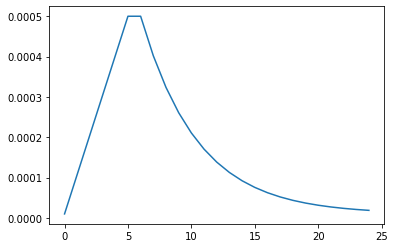

In [36]:
LR_START = 0.00001
LR_MAX = 0.0005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 1
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [37]:
def decode_image(filename, label=None, image_size=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label

In [38]:
def data_augmentation(image, label=None):
    image = tf.image.rot90(image,k=np.random.randint(4))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [39]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augmentation, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(IMG_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [40]:
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [41]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

**EfficientNet - B7**

In [42]:
def build_model():
    with strategy.scope():
        en =efn.EfficientNetB7(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False)
        en.trainable = True

        model = tf.keras.Sequential([
            en,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(train_labels.shape[1], activation='softmax')
        ])
        model.compile(optimizer='adam',
            loss = 'categorical_crossentropy',
            metrics=['categorical_accuracy']
        )
        print(model.summary())
        return model

In [43]:
modelB7 = build_model()

258441216/258434480 [==============================] - 9s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 19, 19, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________
None


In [44]:
%%time
# checkpoint=tf.keras.callbacks.ModelCheckpoint(f"Enet_model.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True,
#        save_weights_only=True,mode='max')

historyB7 = modelB7.fit(
    train_dataset, 
    epochs=EPOCHS,
    validation_data=valid_dataset, 
    verbose=1, 
    callbacks=[lr_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25
12/12 [==============================] - 87s 7s/step - categorical_accuracy: 0.2949 - loss: 1.3822 - val_categorical_accuracy: 0.3905 - val_loss: 1.3441 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000108.
Epoch 2/25
12/12 [==============================] - 16s 1s/step - categorical_accuracy: 0.6777 - loss: 1.1072 - val_categorical_accuracy: 0.7117 - val_loss: 0.9896 - lr: 1.0800e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000206.
Epoch 3/25
12/12 [==============================] - 33s 3s/step - categorical_accuracy: 0.8802 - loss: 0.4244 - val_categorical_accuracy: 0.6460 - val_loss: 1.3319 - lr: 2.0600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000304.
Epoch 4/25
12/12 [==============================] - 32s 3s/step - categorical_accuracy: 0.9089 - loss: 0.2970 - val_categorical_accuracy: 0.8066 - val_loss: 0.5865 - lr: 3.

In [45]:
def plot_training(params, title, ylabel, xlabel, legend=[]):
    plt.plot(params[0])
    plt.plot(params[1])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(legend, loc="lower right")
    plt.show()

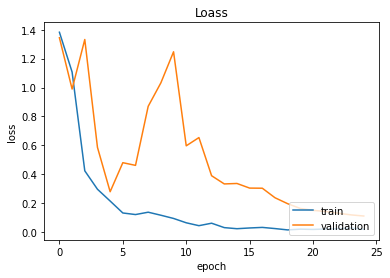

In [46]:
plot_training(
    [historyB7.history["loss"], historyB7.history["val_loss"]],
    "Loass",
    "loss",
    "epoch",
    ["train", "validation"]
)

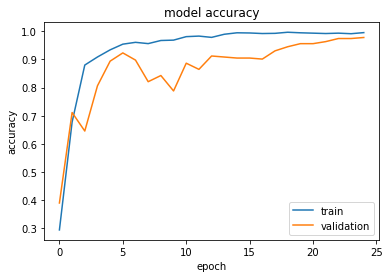

In [47]:
plot_training(
    [historyB7.history["categorical_accuracy"], historyB7.history["val_categorical_accuracy"]],
    "model accuracy",
    "accuracy",
    "epoch",
    ["train", "validation"]
)

In [48]:
# model.load_weights("../input/%s/best_weight.h5" % (os.listdir('../input')[0]))
print("The Accuracy on the Validation data : {:.2f}%".format(100 * modelB7.evaluate_generator(valid_dataset, verbose = 1)[-1]))

3/3 [==============================] - 0s 137ms/step - categorical_accuracy: 0.9781 - loss: 0.1120
The Accuracy on the Validation data : 97.81%


In [49]:
predictedB7 = modelB7.predict(test_dataset,verbose = 1)

15/15 [==============================] - 53s 4s/step


### DenseNet

In [ ]:
def build_densenet_model():
    with strategy.scope():
        dn = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False)
        dn.trainable = True

        model = tf.keras.Sequential([
            dn,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(train_labels.shape[1], activation='softmax')
        ])
        model.compile(optimizer='adam',
            loss = 'categorical_crossentropy',
            metrics=['categorical_accuracy']
        )
        print(model.summary())
        return model

In [ ]:
model_dense = build_densenet_model()

In [ ]:
%%time
# checkpoint=tf.keras.callbacks.ModelCheckpoint(f"Enet_model.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True,
#        save_weights_only=True,mode='max')

historyDense = model_dense.fit(
    train_dataset, 
    epochs=EPOCHS, 
    validation_data=valid_dataset, 
    verbose=1, 
    callbacks=[lr_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
)

In [ ]:
plot_training(
    [historyDense.history["categorical_accuracy"], historyDense.history["val_categorical_accuracy"]],
    "model accuracy",
    "accuracy",
    "epoch",
    ["train", "validation"]
)

In [ ]:
predictDense = model_dense.predict(test_dataset, verbose=1)